# Übungsblatt zu Convolutional Neural Networks (CNN)

Im Folgenden werden wir die Mechaniken der Convolution, ReLu und des Poolings manuell durchführen. Danach schauen wir uns das
Ganze einmal mit einem vorgefertigten Paket, dem openCV Paket an.

Zuerst importieren wir nötige Pakete, numpy zur Datenvorverarbeitung und seaborn zur visuellen Darstellung der Ergebnisse. Danach implementieren wir die Funktionen isSquare (Überprüfung, ob eine Liste in quadratischer Form vorliegt) und prepare_for_heatmap (Datenvorverarbeitung für das von seaborn verwendete Format), welche wir im weiteren Verlauf noch benötigen werden.

In [1]:
import numpy as np

# Seaborn wird für das Visualisieren der Bild-Arrays verwendet
from seaborn import heatmap

In [2]:
def isSquare(arr: list, check_type: bool = True) -> bool:
    """Überprüft, ob die übergebene Liste quadratisch ist.
    check_type überprüft, dass der innere Typ keine weitere Liste ist."""
    
    outer_count = len(arr)
    for inner in arr:
        if len(inner) != outer_count:
            return False
        
        if check_type and any(type(el) is list for el in inner):
            return False
        
    return True


In [3]:
def prepare_for_heatmap(ergebnis: list, rows: int, cols: int) -> list:
    """Formatierung für heatmap Funktion"""
    
    a = 0
    b = cols
    heat = []

    for i in range(rows):
        heat.append(ergebnis[a:b])
        a += cols
        b += cols
    
    return heat

Nun wird das Bild in Form einer zweidimensionalen Liste erzeugt. Dabei werden die Werte -1 (schwarz) und 1 (weiß) verwendet. Wir zeichnen hier ein Quadrat. Darauf folgt eine Visualisierung mit einer Heatmap, in denen wir sehen können, ob wir die richtigen Werte verwendet haben.


[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  1  1  1  1  1  1  1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1  1  1  1  1  1  1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]]


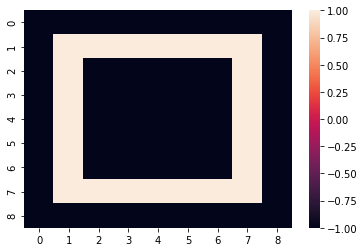

In [4]:
# Setup Bild 1
bild1 = [
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1,  1,  1,  1,  1,  1,  1,  1, -1],
    [-1,  1, -1, -1, -1, -1, -1,  1, -1],
    [-1,  1, -1, -1, -1, -1, -1,  1, -1],
    [-1,  1, -1, -1, -1, -1, -1,  1, -1],
    [-1,  1, -1, -1, -1, -1, -1,  1, -1],
    [-1,  1, -1, -1, -1, -1, -1,  1, -1],
    [-1,  1,  1,  1,  1,  1,  1,  1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1]
]

print(np.array(bild1))
_ = heatmap(bild1)

Das sieht doch gut aus! Anschließend definieren wir unsere Kernels (Filter). Diese repräsentieren die besonderen Merkmale unserer gesuchten, geometrischen Form. 

In [5]:
# Setup kernels

kernel3 = [
    [1,  1,  1],
    [1, -1, -1],
    [1, -1, -1]
]

kernel4 = [
    [ 1,  1, 1],
    [-1, -1, 1],
    [-1, -1, 1]
]

kernel5 = [
    [1, -1, -1],
    [1, -1, -1],
    [1,  1,  1]
]

kernel6 = [
    [-1, -1, 1],
    [-1, -1, 1],
    [ 1, -1, 1]
]

Hier wird eine Klasse "Pixel" erstellt, mit der das folgende Iterieren über das Bild mit unseren Kernels verständlicher wird.

In [6]:
class Pixel:
    
    def __init__(self, row: int, column: int):
        self.row = row
        self.column = column
        self.__original_column = column
    
    def get_info_from_image(self, img: list):
        return img[self.row][self.column]
    
    def move_to_next_line(self):
        self.row += 1
        self.column = self.__original_column
    
    def __repr__(self):
        return f"({self.row}, {self.column})"

In der Funktion kernel_iterate verwenden wir nun ein Bild und einen Kernel, um den Kernel schrittweise über das Bild laufen zu lassen. Dabei wird immer ein 3x3-Zielausschnitt des Bildes genommen und mit dem Kernel multipliziert. Von den 9 Ergebnissen wird dann der Durchschnitt gebildet und in die Ergebnisliste eingetragen. Der Kernel bewegt sich immer in 1er-Schritten.

In [7]:
def kernel_iterate(kernel: list, bild: list):
    """kernel und bild sollten eine Liste mit weiteren Listen als Inhalt sein."""
    
    ergebnis = [] # die fertige feature map
    ziel = [] # aktuell betrachterter Ausschnitt
    
    frame = [] # ist die aktuelle Position des Kernels
    for i in range(len(kernel)):
        for j in range(len(kernel[i])):
            frame.append(Pixel(i, j));
    
    # Ausschnitt wird aktualisiert
    for i in range(2, 9, 3):
        ziel.append([frame[i - 2].get_info_from_image(bild), frame[i - 1].get_info_from_image(bild), frame[i].get_info_from_image(bild)])

    # durch alle Pixel des Bilds durchiterieren
    for y in range(1, 8):
        for i in range(1, 8):
            zwischenspeicher = []
            
            for k, element in enumerate(kernel):
                for j, zahl in enumerate(ziel[k]):
                    zwischenspeicher.append(element[j] * zahl)
                    
            ergebnis.append(np.average(zwischenspeicher))

            # die Kernelposition um eine Spalte verschieben 
            for pixel in frame:
                pixel.column += 1
            
            # Ende des Bilds erreicht
            if frame[2].column < len(bild[0]):
                ziel = []
                # Ausschnitt neu bestimmen
                for i in range(2, 9, 3):
                    ziel.append([frame[i - 2].get_info_from_image(bild), frame[i - 1].get_info_from_image(bild), frame[i].get_info_from_image(bild)])
        
        # Kernelposition um eine Zeile verschieben
        for pixel in frame:
            pixel.move_to_next_line()
        
        # Ende des Bilds erreicht
        if frame[6].row < len(bild):
            ziel = []
            # Ausschnitt neu bestimmen
            for i in range(2, 9, 3):
                ziel.append([frame[i - 2].get_info_from_image(bild), frame[i - 1].get_info_from_image(bild), frame[i].get_info_from_image(bild)])
    return ergebnis

Nun können wir unser Ergebnis mithilfe der am Anfang definierten prepare_for_heatmap Funktion visualisieren. Hier sieht man sehr schön, wie die Ecke in unserem Kernel im Bild erkannt wird.

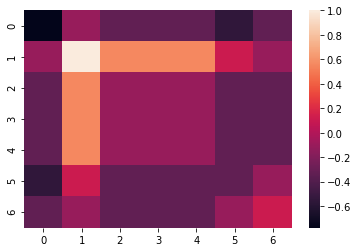

In [8]:
ergebnis = kernel_iterate(kernel3, bild1)

DIMENSIONS = 7

_ = heatmap(prepare_for_heatmap(ergebnis, DIMENSIONS, DIMENSIONS))

Die Convolution ist damit für unser Beispiel abgeschlossen. Jetzt definieren wir die ReLu Funktion, die alle Ergebnisse, welche <0 sind, durch 0 ersetzt.

In [9]:
def relu(liste: list):
    ergebnis = []
    for zahl in liste:
        if zahl < 0:
            a = 0
        else:
            a = zahl
        ergebnis.append(a)
    return ergebnis

Wenn wir dies nun visualisieren, können wir unsere Ecke noch viel besser erkennen. Für das neuronale Netzwerk werden darüber hinaus Rechenkapazitäten eingespart, da viele Neuronen nun nicht geladen werden müssen. 

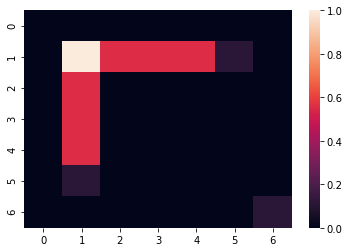

In [18]:
ergebnis = kernel_iterate(kernel3, bild1)
ergebnisRelu = relu(ergebnis)
ergebnisReluH = prepare_for_heatmap(ergebnisRelu, 7, 7)
_ = heatmap(ergebnisReluH)

Zum Schluss führen wir ein Pooling durch, bei dem das Bild in Zweierschritten mit einem 2x2-Zielausschnitt abgefahren wird und aus den vier Ergebnissen der Maximalwert in eine Ergebnisliste eingetragen wird.

In [11]:
def pooling(ergMa: list):
    """Die Ergebnismatrix (ergMa) sollte eine Liste mit weiteren Listen als Inhalt sein."""
    ergebnis = []
    a = 0
    b = 0
    c = 0
    d = 1
    e = 1
    f = 0
    g = 1
    h = 1

    #Pruefen, ob ungerade Anzahl an Zeilen und Spalten. 
    #Wenn die Anzahl ungerade ist wird eine Spalte, bzw. eine Zeile hinzugefügt.
    if (len(ergMa) % 2) > 0:
        ergMa.append([0, 0, 0, 0, 0, 0, 0, 0])
    if (len(ergMa[0])) % 2 > 0:
        for liste in ergMa:
            liste.append(0)
    print(ergMa)
        
        
    i = 1
    j = 1
    #Für jede Zeile
    while j < 5:
        #Für jede Spalte
        while i < 5:
            #Prüfen, ob am Ende der Spalte oder Zeile angekommen.
            if (a < 7) and (b < 7): 
                #Maximalwert des 2x2 Auschnitts wird genommen und in die Ergebnisliste eingetragen. Danach rückt
                #der Zielausschnitt in Zweierschritten weiter.
                ziel = [ergMa[a][b], ergMa[c][d], ergMa[e][f], ergMa[g][h]]
                ergebnis.append(max(ziel))  
            b += 2
            d += 2
            f += 2
            h += 2
            
            i += 1
        i = 0
        b = 0
        d = 1
        f = 0
        h = 1
        j += 1
        a += 2
        c += 2
        e += 2
        g += 2
            
    return ergebnis
    
    

Wenn wir unsere neue Ergebnismatrix visualisieren, sehen wir, dass wir durch das Pooling einen kleineren Bildausschnitt bekommen, ohne dabei wichtige Informationen zu verlieren.

[[0, 0, 0, 0, 0, 0, 0, 0], [0, 1.0, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.1111111111111111, 0, 0], [0, 0.5555555555555556, 0, 0, 0, 0, 0, 0], [0, 0.5555555555555556, 0, 0, 0, 0, 0, 0], [0, 0.5555555555555556, 0, 0, 0, 0, 0, 0], [0, 0.1111111111111111, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.1111111111111111, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]


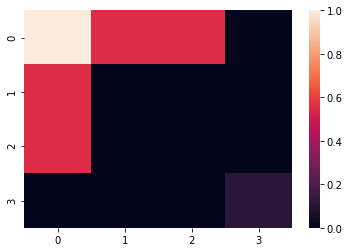

In [19]:
ergMa = pooling(ergebnisReluH)

_ = heatmap(prepare_for_heatmap(ergMa, 4, 4))

<h1> Aufgabe für euch! </h1>
Hands on!
Nun seid ihr an der Reihe! <br>
<b>Aufgabe 1</b>: Erstellt eine zweidimensionale Liste mit den Werten -1 und 1 für ein Dreieck. Das Dreieck soll wie in der Präsentation dargestellt aussehen. <br>
<b>Aufgabe 2</b>: Erstellt einen Kernel, der für das Erkennen der linken unteren Ecke des Dreiecks angemessen ist. <br>
Tipp: Der Kernel beginnt in Zeile fünf und Spalte eins. <br>
<b>Aufgabe 3</b>: Führt die Convolution, ReLu und das Pooling für euer Bild und euren Kernel mit den vorher definierten Funktionen durch. Das Ergebnis könnt ihr in der Präsentation sehen :)

Zunächst erstellen wir das Bild in einem zweidimensionalen Array und visualieren es dann mittels der Heatmap Funktion von seaborn.

[[-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1 -1]
 [-1 -1 -1  1 -1  1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1  1 -1 -1]
 [-1  1 -1 -1 -1 -1 -1  1 -1]
 [-1  1  1  1  1  1  1  1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1]]


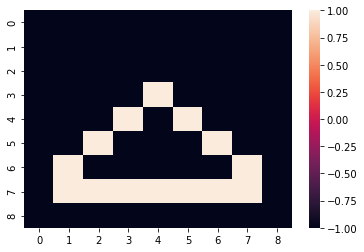

In [20]:
# Setup Bild Dreieck
bild2 = [
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, 1, -1, -1, -1, -1],
    [-1, -1, -1, 1, -1, 1, -1, -1, -1],
    [-1, -1, 1, -1, -1, -1, 1, -1, -1],
    [-1, 1, -1, -1, -1, -1, -1, 1, -1],
    [-1, 1, 1,  1,  1,  1,  1, 1, -1],
    [-1, -1, -1, -1, -1, -1, -1, -1, -1]
]

print(np.array(bild2))
_ = heatmap(bild2)

Dann erstellen wir den Kernel für die linke untere Ecke. 

In [21]:
# Kernel Dreieck
kernel1 = [
    [-1, 1, -1],
    [1, -1, -1],
    [1, 1, 1]
]

Folgend führen wir eine Convolution durch, indem wir die kernel_iterate Funktion mit unserem Kernel und dem Bild als Parameter aufrufen. Danach bringen wir die Ergebnisliste der prepare_for_heatmap Funktion in das für die Visualisierung mit seaborn benötigte Datenformat.

<AxesSubplot:>

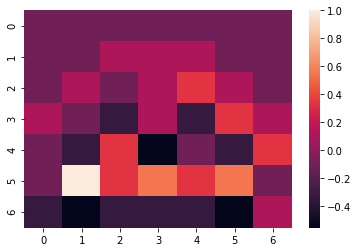

In [22]:
convDreieck = kernel_iterate(kernel1, bild2)
convDreieckH = prepare_for_heatmap(convDreieck, 7, 7)
heatmap(convDreieckH)

Die ReLu Funktion wird dann mit unserer Ergebnisliste aufgerufen, in das Heatmap-Datenformat konvertiert und visualisiert.

<AxesSubplot:>

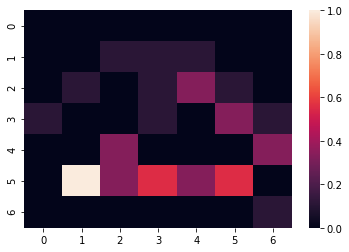

In [23]:
dreieckRelu = relu(convDreieck)
dreieckReluH = prepare_for_heatmap(dreieckRelu, 7, 7)
heatmap(dreieckReluH)

Zuletzt führen wir ein Pooling durch, indem wir das Datenformat der vorherigen Heatmap als Parameter für die Pooling Funktion nutzen. Das Ergebnis wird wieder konvertiert und visualisiert. 

[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0, 0, 0], [0, 0.1111111111111111, 0, 0.1111111111111111, 0.3333333333333333, 0.1111111111111111, 0, 0], [0.1111111111111111, 0, 0, 0.1111111111111111, 0, 0.3333333333333333, 0.1111111111111111, 0], [0, 0, 0.3333333333333333, 0, 0, 0, 0.3333333333333333, 0], [0, 1.0, 0.3333333333333333, 0.5555555555555556, 0.3333333333333333, 0.5555555555555556, 0, 0], [0, 0, 0, 0, 0, 0, 0.1111111111111111, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]


<AxesSubplot:>

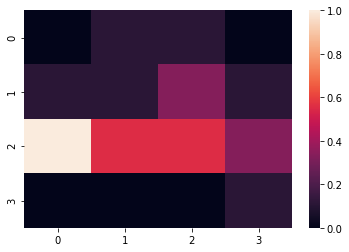

In [24]:
dreieckPooling = pooling(dreieckReluH)
dreieckPoolingH = prepare_for_heatmap(dreieckPooling, 4, 4)
heatmap(dreieckPoolingH)